# Block Model with a 1D background -- Comparison

### For the model, see the notebook BlockModel.ipynb

We'll have to add detail information about

- How many cells
- How many threads
- CPU
- RAM
- On what type of machine run

We should do that in detail at the end. Here some preliminary info from your comments:

(emg3d took quite long (but on one thread), as I discretized it very finely, which can be seen in the rather precise 1D result. I might coarsen it later on, to get faster speed at the cost of precision, to be in a similar ballpark.)

### emg3d
- 4,718,592 cells
- 13 minutes
- 1 thread
- ~ 1 GB RAM
- My Laptop

### custEM
- ?? cells
- 90 s
- 32 cores/threads
- ?? RAM
- Server?

### PETGEM
- ?? cells
- 120 s
- 24 cores/threads
- ?? RAM
- Server


In [1]:
import emg3d
import discretize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Survey parameters

In [3]:
# Source: x-directed electric dipole of 200 m length, 50 meter above seafloor
src = np.array([-100, 100, 0, 0, -550, -550])
src_c = np.mean(src.reshape(-1, 2), 1)

# 3 Receiver lines
rec_x = np.linspace(-10, 10, 101)*1e3
rec_y = np.array([-3, 0, 3])*1e3
rec_z = -600

## Load data
### Semi-analytical background result from `empymod`

In [4]:
epm_1d = np.load('../data/emg3d_results/epm1_1d.npy')

### `emg3d`

In [5]:
# BACKGROUND
egd_bg = np.load('../data/emg3d_results/egd_bg.npy')
# 3D
egd = np.load('../data/emg3d_results/egd.npy')

### `PETGEM`

In [6]:
# BACKGROUND
ptg0 = np.load('../data/petgem_results_blockModel/y_0_E_bm.npy')
# ptgp = np.load('../data/petgem_results_blockModel/y_3000_E_bm.npy')
ptgm = np.load('../data/petgem_results_blockModel/y_-3000_E_bm.npy')
ptg_bg = np.vstack([ptgm[:, 0], ptg0[:, 0]]).T
# Take conjugate, PETGEM uses -iwt, as oposed to emg3d/custEM which have iwt.
ptg_bg = ptg_bg.conj()

# 3D
ptg0 = np.load('../data/petgem_results_blockModel/y_0_E_le.npy')
ptgp = np.zeros((101, 3), dtype=complex)                                          # OCTAVIO, y_3000_E_le has one entry less?
ptgp[:-1, :] = np.load('../data/petgem_results_blockModel/y_3000_E_le.npy')
ptgm = np.load('../data/petgem_results_blockModel/y_-3000_E_le.npy')
ptg = np.vstack([ptgm[:, 0], ptg0[:, 0], ptgp[:, 0]]).T
# Take conjugate, PETGEM uses -iwt, as oposed to emg3d/custEM which have iwt.
ptg = ptg.conj()

### `custEM`

In [12]:
# BACKGROUND
cst0 = np.load('../data/custEM_results/y_0_E_le_p2.npy')
# cstp = np.load('../data/custEM_results/y_3000_E_le.npy')
cstm = np.load('../data/custEM_results/y_-3000_E_le_p2.npy')
cst_bg = np.vstack([cstm[:, 0], cst0[:, 0]]).T #, cstp[:, 0]]).T

# 3D
cst0 = np.load('../data/custEM_results/y_0_E_bm_p2.npy')
cstp = np.load('../data/custEM_results/y_3000_E_bm_p2.npy')
cstm = np.load('../data/custEM_results/y_-3000_E_bm_p2.npy')
cst = np.vstack([cstm[:, 0], cst0[:, 0], cstp[:, 0]]).T

## Compare 1D background

In [13]:
# Calculate error
egd_rerr = np.clip(100*abs((epm_1d.real-egd_bg.real)/epm_1d.real), 0.01, 100)
cst_rerr = np.clip(100*abs((epm_1d.real-cst_bg.real)/epm_1d.real), 0.01, 100)
ptg_rerr = np.clip(100*abs((epm_1d.real-ptg_bg.real)/epm_1d.real), 0.01, 100)
egd_ierr = np.clip(100*abs((epm_1d.imag-egd_bg.imag)/epm_1d.imag), 0.01, 100)
cst_ierr = np.clip(100*abs((epm_1d.imag-cst_bg.imag)/epm_1d.imag), 0.01, 100)
ptg_ierr = np.clip(100*abs((epm_1d.imag-ptg_bg.imag)/epm_1d.imag), 0.01, 100)

<IPython.core.display.Javascript object>


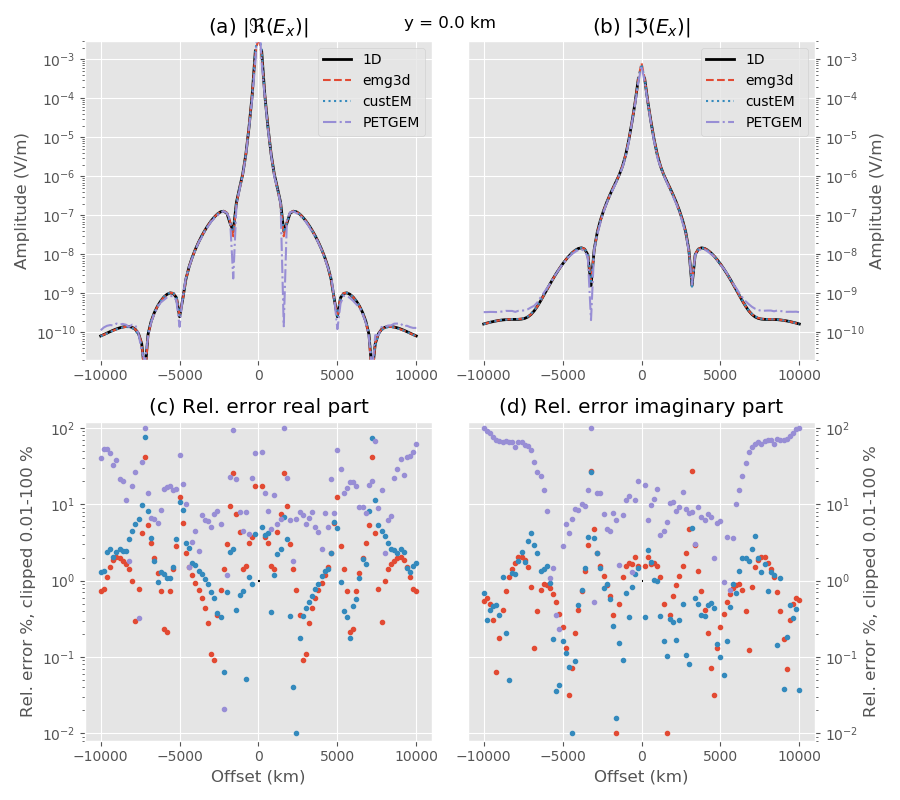

In [14]:
plt.figure(figsize=(9, 8))
plt.suptitle(f'y = {rec_y[1]/1e3} km')
# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 1].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 1].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 1].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 1].real), f'C2-.', label=f'PETGEM')

plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 1].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 1].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 1].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 1].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

plt.plot(rec_x, egd_rerr[:, 1], 'C0.')
plt.plot(rec_x, cst_rerr[:, 1], 'C1.')
plt.plot(rec_x, ptg_rerr[:, 1], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

plt.plot(rec_x, egd_ierr[:, 1], 'C0.')
plt.plot(rec_x, cst_ierr[:, 1], 'C1.')
plt.plot(rec_x, ptg_ierr[:, 1], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


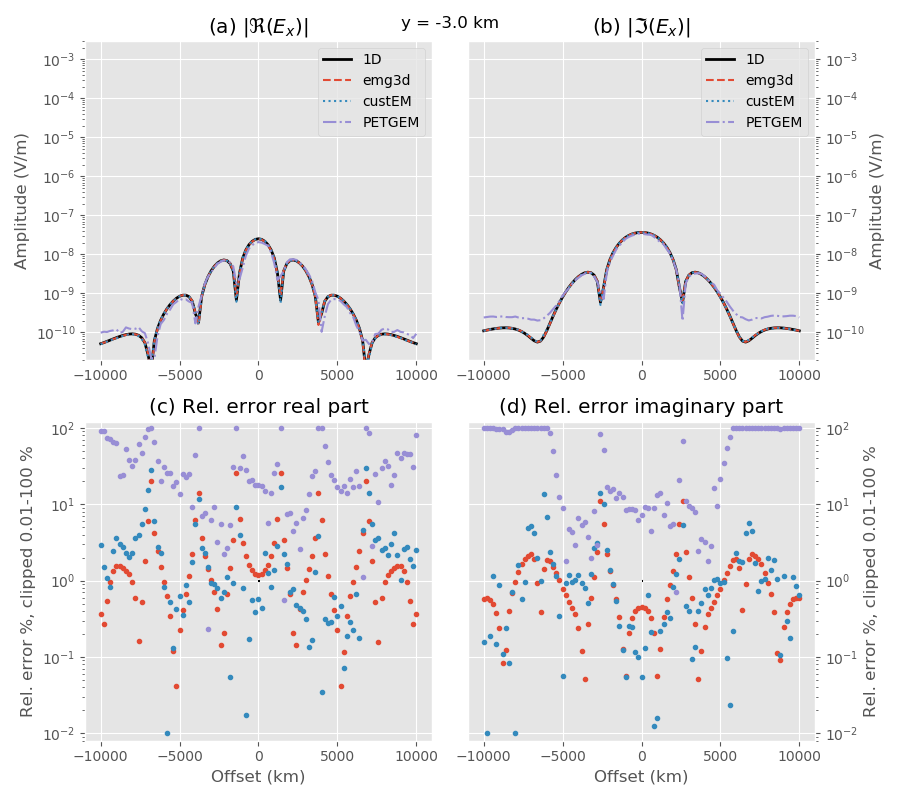

In [15]:
plt.figure(figsize=(9, 8))
plt.suptitle(f'y = {rec_y[0]/1e3} km')
# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 0].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 0].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 0].real), f'C2-.', label=f'PETGEM')

plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 0].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst_bg[:, 0].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg_bg[:, 0].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

plt.plot(rec_x, egd_rerr[:, 0], 'C0.')
plt.plot(rec_x, cst_rerr[:, 0], 'C1.')
plt.plot(rec_x, ptg_rerr[:, 0], 'C2.')

plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

plt.plot(rec_x, egd_ierr[:, 0], 'C0.')
plt.plot(rec_x, cst_ierr[:, 0], 'C1.')
plt.plot(rec_x, ptg_ierr[:, 0], 'C2.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-100 %')
plt.ylim([0.008, 120])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

## Compare 3D model

<IPython.core.display.Javascript object>


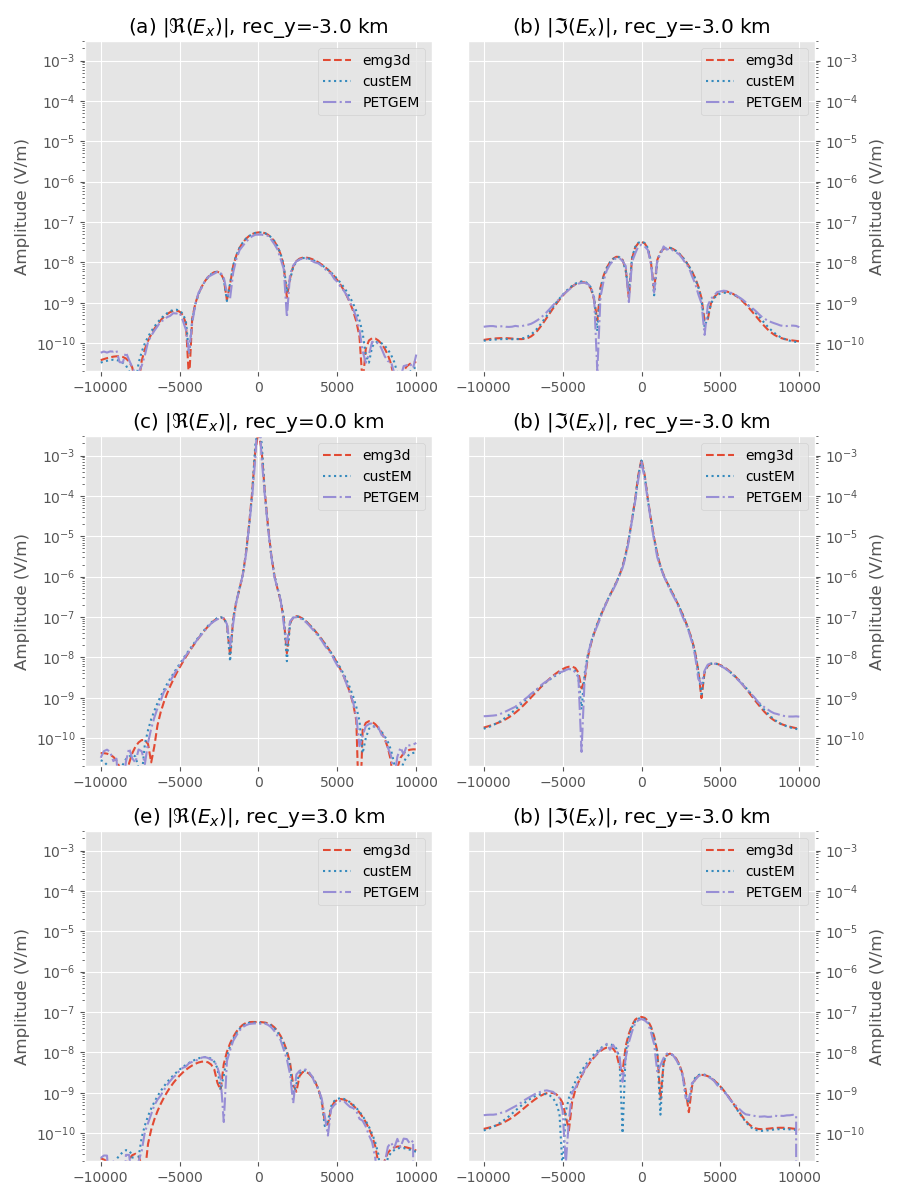

In [16]:
plt.figure(figsize=(9, 12))

# Real
ax1 = plt.subplot(321)
plt.title(f'(a) $|\Re(E_x)|$, rec_y={rec_y[0]/1e3} km')
plt.plot(rec_x, abs(egd[:, 0].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 0].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 0].real), f'C2-.', label=f'PETGEM')
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax3 = plt.subplot(323, sharey=ax1)
plt.title(f'(c) $|\Re(E_x)|$, rec_y={rec_y[1]/1e3} km')
plt.plot(rec_x, abs(egd[:, 1].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 1].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 1].real), f'C2-.', label=f'PETGEM')
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax5 = plt.subplot(325, sharey=ax1)
plt.title(f'(e) $|\Re(E_x)|$, rec_y={rec_y[2]/1e3} km')
plt.plot(rec_x, abs(egd[:, 2].real), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 2].real), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 2].real), f'C2-.', label=f'PETGEM')
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')


# Imaginary
ax2 = plt.subplot(322, sharey=ax1)
plt.title(f'(b) $|\Im(E_x)|$, rec_y={rec_y[0]/1e3} km')

plt.plot(rec_x, abs(egd[:, 0].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 0].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 0].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

ax4 = plt.subplot(324, sharey=ax1)
plt.title(f'(b) $|\Im(E_x)|$, rec_y={rec_y[0]/1e3} km')

plt.plot(rec_x, abs(egd[:, 1].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 1].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 1].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

ax6 = plt.subplot(326, sharey=ax1)
plt.title(f'(b) $|\Im(E_x)|$, rec_y={rec_y[0]/1e3} km')

plt.plot(rec_x, abs(egd[:, 2].imag), f'C0--', label=f'emg3d')
plt.plot(rec_x, abs(cst[:, 2].imag), f'C1:', label=f'custEM')
plt.plot(rec_x, abs(ptg[:, 2].imag), f'C2-.', label=f'PETGEM')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax6.yaxis.set_ticks_position('right')
ax6.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

In [17]:
emg3d.Report([discretize])

--------------------------------------------------------------------------------
  Date: Tue Jan 14 16:35:18 2020 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.4.10 : discretize
            1.17.4 : numpy
             1.3.2 : scipy
            0.46.0 : numba
0.9.3.dev4+g8528f83 : emg3d
            7.10.2 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------